## Load Dataset

In [1]:
import networkx as nx
import os
RANDOM_STATE = 5664
def load_network(edge_list_file):
    """
    Load a network from an edge list file.
    
    Args:
        edge_list_file (str): Path to the edge list file
        
    Returns:
        networkx.Graph: The loaded network graph
    """
    try:
        # Check if file exists and has content
        if not os.path.exists(edge_list_file) or os.path.getsize(edge_list_file) == 0:
            raise FileNotFoundError(f"Edge list file not found or empty: {edge_list_file}")
        
        # Load the network
        G = nx.read_edgelist(edge_list_file)
        print(f"Network loaded from {edge_list_file}")
        print(f"  Number of nodes: {G.number_of_nodes()}")
        print(f"  Number of edges: {G.number_of_edges()}")
        print(f"\tNetwork density: {nx.density(G):.4f}")      
        
        return G
    
    except Exception as e:
        print(f"Error in load_network: {str(e)}")
        raise

# Load the network
edge_list_file_vec = "network_similarity_vec.csv"
G = load_network(edge_list_file_vec)

Network loaded from network_similarity_vec.csv
  Number of nodes: 8630
  Number of edges: 647783
	Network density: 0.0174


## Degree Distribution Analysis

In [2]:
import numpy as np
# Small world and heavy-tail analysis

degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
print("Basic degree statistics:")
print(f"\tTotal degree: {sum(degree_sequence)}")
print(f"\tMinimum degree: {np.min(degree_sequence)}")
print(f"\tMaximum degree: {np.max(degree_sequence)}")
print(f"\tMean degree: {np.mean(degree_sequence):.2f}")
print(f"\tMedian degree: {np.median(degree_sequence)}")

Basic degree statistics:
	Total degree: 1295566
	Minimum degree: 1
	Maximum degree: 562
	Mean degree: 150.12
	Median degree: 118.0


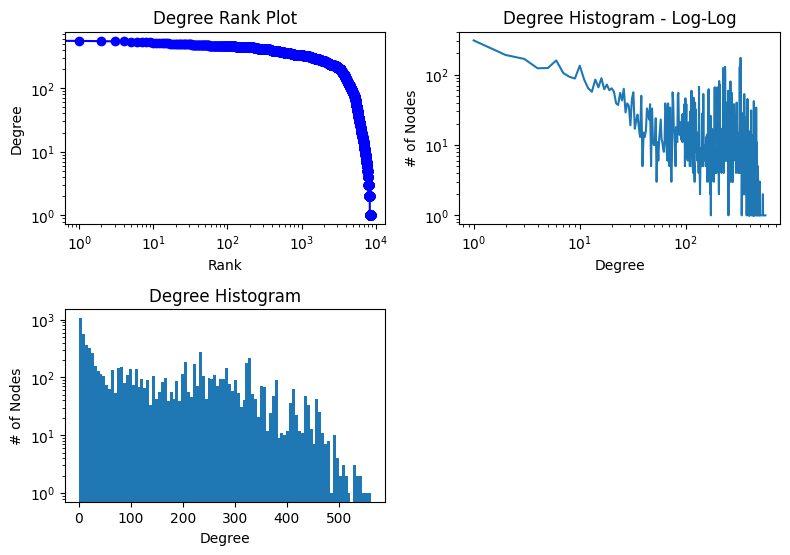

In [3]:
import matplotlib.pyplot as plt

def plot_degree_sequence(degrees):
    fig = plt.figure("Degree Distribution Analysis", figsize=(8, 8))
    axgrid = fig.add_gridspec(3, 2)
    
    # Subplot 1: Degree rank plot
    ax1 = fig.add_subplot(axgrid[0, 0])
    ax1.loglog(degrees, "b-", marker="o")
    ax1.set_title("Degree Rank Plot")
    ax1.set_ylabel("Degree")
    ax1.set_xlabel("Rank")
    
    # Subplot 2: Degree histogram
    ax2 = fig.add_subplot(axgrid[1, 0])
    ax2.hist(degrees, bins=100, log=True)
    ax2.set_title("Degree Histogram")
    ax2.set_xlabel("Degree")
    ax2.set_ylabel("# of Nodes")
    
    # Subplot 3: Degree Log Scale
    ax3 = fig.add_subplot(axgrid[0, 1])
    ax3.loglog(*np.unique(degrees, return_counts=True))
    ax3.set_title("Degree Histogram - Log-Log")
    ax3.set_xlabel("Degree")
    ax3.set_ylabel("# of Nodes")
    
    fig.tight_layout()
    plt.show()
plot_degree_sequence(degree_sequence)

## Connected Component Analysis

In [4]:
def giant_network_analysis(G):
    """
    Perform basic analysis on a network graph.
    
    Args:
        G (networkx.Graph): The network graph to analyze
        
    Returns:
        networkx.Graph: The analyzed network graph
    """
    try:
        print(f"\nNetwork Analysis:")

        # Connected components analysis
        num_components = nx.number_connected_components(G)
        print(f"  Number of connected components: {num_components}")
        
        largest_cc = None
        if num_components > 0:
            # Get largest connected component
            largest_cc = max(nx.connected_components(G), key=len)
            largest_cc_size = len(largest_cc)
            print(f"  Size of largest connected component: {largest_cc_size} nodes")
            print(f"  Percentage of nodes in largest component: {largest_cc_size/G.number_of_nodes()*100:.2f}%")
        
        return largest_cc
    
    except Exception as e:
        print(f"Error in analyze_network: {str(e)}")
        raise

# Analyze the network
Giant = giant_network_analysis(G)


Network Analysis:
  Number of connected components: 123
  Size of largest connected component: 8244 nodes
  Percentage of nodes in largest component: 95.53%


In [5]:
import random

g_cc = G.subgraph(Giant).copy()
shortest_path_avg = nx.average_shortest_path_length(g_cc)
print(f"Average shortest path in the giant component: {shortest_path_avg}")
diameter = nx.diameter(g_cc)
print(f"Diameter of the giant component: {diameter}")
# 
# # Finding the APSP is very computation heavy and is infeasible for a graph this large so take an approximation
# 
# # Network diameter
# # Do multiple runs to get a better approximation
# def approximate_diameter(graph, runs=20):
#     diameters = []
#     for i in range(runs):
#         if i%5==0:
#             print(f"Running iteration {i}")
#         diameters.append(nx.algorithms.approximation.diameter(graph))
#     return max(diameters)
# 
# # Network average shortest path
# # Do multiple runs to get a better approximation
# # https://stackoverflow.com/questions/67496060/networkx-average-shortest-path-length-and-diameter-is-taking-forever
# def approximate_average_shortest_path(giant_component, runs=1000):
#     total = 0
#     nodes = list(giant_component.nodes())
#     for i in range(runs):
#         if i%100==0:
#             print(f"Running iteration {i}")
#         u, v = random.sample(nodes, 2) # get two random nodes
#         length = nx.shortest_path_length(giant_component, u, v)
#         total += length
#     return total/runs
# 
# 
# diameter = approximate_diameter(g_cc)
# print(f"Approximate network diameter: {diameter:.4f}")
# 
# shortest_path_avg = approximate_average_shortest_path(g_cc)
# print(f"Network shortest average path: {shortest_path_avg:.4f}")
#         


# 29 minutes

KeyboardInterrupt: 

In [ ]:
# TODO: We can do gephi too. Thoughts?

## Centrality Analysis

In [6]:
# Set up parallelization (use latest nx version, also install nx-parallel)
nx.config.backends.parallel.active = True
nxp_config = nx.config.backends.parallel
nxp_config.n_jobs = 8
nxp_config.verbose = 50

In [7]:
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G, normalized=True, backend="parallel")
# Take a sample of closeness and discuss the distribution
sample = random.sample(list(G.nodes), 1000)
closeness_centrality = {node: nx.closeness_centrality(G, node) for node in sample} # 2 minutes to run
 

top_5_degree = sorted(degree_centrality.items(),  key=lambda x: x[1], reverse=True)[:5]
top_5_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
top_5_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

print("Top 5 Nodes by Degree Centrality:", top_5_degree)
print("Top 5 Nodes by Betweenness Centrality:", top_5_betweenness)
print("Top 5 Nodes by Closeness Centrality:", top_5_closeness)



# TODO: mean. plot the distribution of closeness, plus other graphs for centrality
# 8 minutes

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:  8.5min
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed: 10.0min remaining: 29.9min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed: 10.0min remaining: 16.7min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed: 10.0min remaining: 10.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed: 10.1min remaining:  6.0min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed: 10.1min remaining:  3.4min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed: 10.2min finished
Top 5 Nodes by Degree Centrality: [('TheSeeker80', 0.06512921543631939), ('Far-Ad3683', 0.06408622088306871), ('Kolobok85', 0.0633908911809016), ('JediBlight', 0.06315911461351258), ('InternationalStep788', 0.0626955614787345)]
Top 5 Nodes by Betweenness Centrality: [('Hrit33', 0.025148323459401368), ('leeverpool', 0.015861619431034178), ('blueskydragonFX', 0.015785682264295445), ('Soft-Post

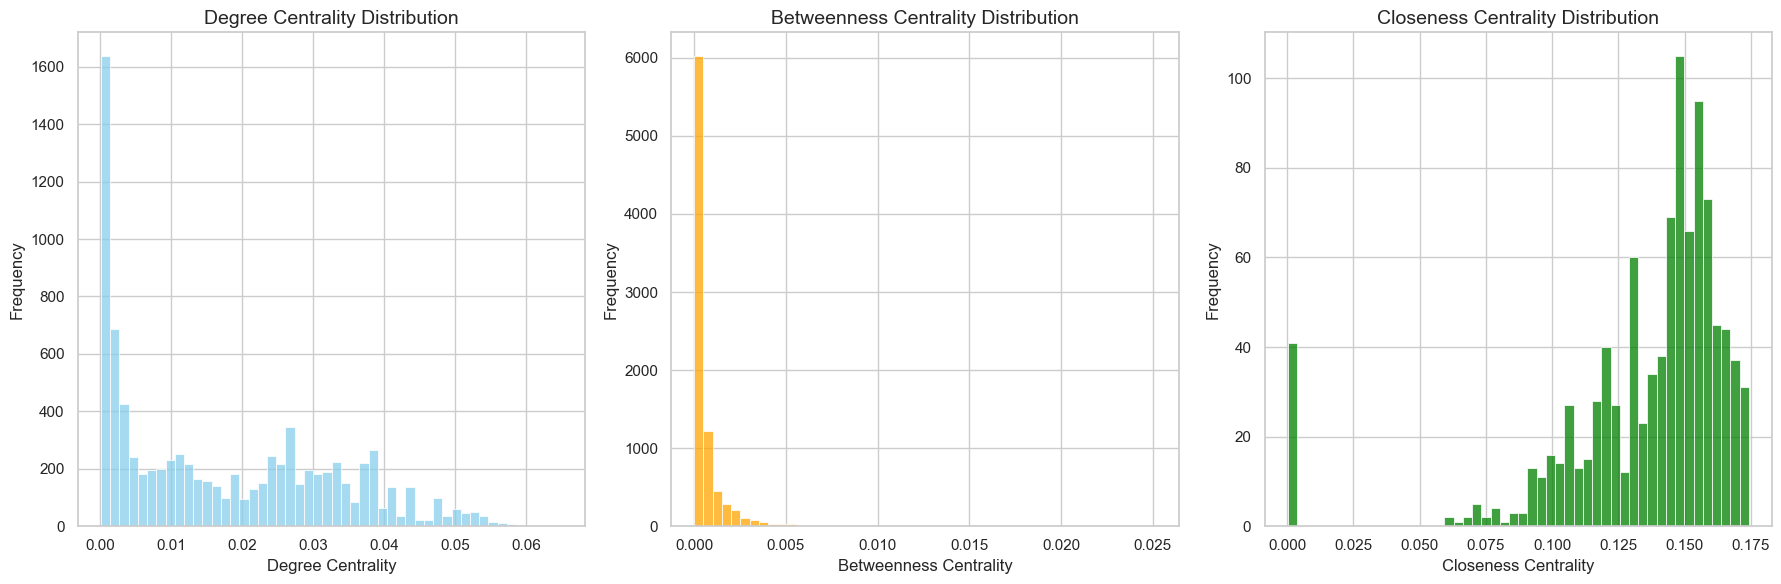

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_centrality_distributions(degree_centrality, betweenness_centrality, closeness_centrality):
    """
    Plot the distributions of Degree Centrality, Betweenness Centrality, and Closeness Centrality.
    """
    # Convert centrality values to lists for plotting
    degree_values = list(degree_centrality.values())
    betweenness_values = list(betweenness_centrality.values())
    closeness_values = list(closeness_centrality.values())

    # plotting style
    sns.set_theme(style="whitegrid")

    # Create a figure with subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

    # Degree Centrality Distribution
    sns.histplot(degree_values, bins=50, color="skyblue", ax=axes[0])
    axes[0].set_title("Degree Centrality Distribution", fontsize=14)
    axes[0].set_xlabel("Degree Centrality", fontsize=12)
    axes[0].set_ylabel("Frequency", fontsize=12)

    # Betweenness Centrality Distribution
    sns.histplot(betweenness_values, bins=50, color="orange", ax=axes[1])
    axes[1].set_title("Betweenness Centrality Distribution", fontsize=14)
    axes[1].set_xlabel("Betweenness Centrality", fontsize=12)
    axes[1].set_ylabel("Frequency", fontsize=12)

    # Closeness Centrality Distribution
    sns.histplot(closeness_values, bins=50, color="green", ax=axes[2])
    axes[2].set_title("Closeness Centrality Distribution", fontsize=14)
    axes[2].set_xlabel("Closeness Centrality", fontsize=12)
    axes[2].set_ylabel("Frequency", fontsize=12)

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

# Plot the distributions
plot_centrality_distributions(degree_centrality, betweenness_centrality, closeness_centrality)

## Clustering analysis

In [9]:
# Clustering coefficient for each node
clustering_coeffs = nx.clustering(G)

# average clustering coefficient
avg_clustering = nx.average_clustering(G)

# Compute global clustering coefficient
global_clustering = nx.transitivity(G)

# Print results
print(f"Minimum Clustering Coefficient: {min(clustering_coeffs.values())}")
print(f"Maximum Clustering Coefficient: {max(clustering_coeffs.values())}")
print(f"Average Clustering Coefficient: {avg_clustering:.6f}")
print(f"Global Clustering Coefficient: {global_clustering:.6f}")

# 3 minutes

Minimum Clustering Coefficient: 0
Maximum Clustering Coefficient: 1.0
Average Clustering Coefficient: 0.739996
Global Clustering Coefficient: 0.750133


In [10]:
# Generating Watts-Strogatz small-world network
WS_graph = nx.watts_strogatz_graph(G.number_of_nodes(), round(np.mean(degree_sequence)), 0.1)

# Computing metrics for Watts-Strogatz model
ws_avg_clustering = nx.average_clustering(WS_graph)
ws_global_clustering = nx.transitivity(WS_graph)
ws_avg_shortest_path = nx.average_shortest_path_length(WS_graph)

# Print comparison
print(f"Average Clustering Coefficient Watts-Strogatz: {ws_avg_clustering:.4f}")
print(f"Global Clustering Coefficient Watts-Strogatz: {ws_global_clustering:.4f}")
print(f"Average Shortest Path Length Watts-Strogatz: {ws_avg_shortest_path:.4f}")

# 1 minute

Average Clustering Coefficient Watts-Strogatz: 0.5451
Global Clustering Coefficient Watts-Strogatz: 0.5445
Average Shortest Path Length Watts-Strogatz: 2.5656


## Small World Property Check

In [11]:
print(f"Network shortest average path: {shortest_path_avg:.4f}")
print(f"Average Clustering Coefficient: {avg_clustering:.6f}")
print(f"Global Clustering Coefficient: {global_clustering:.6f}")

print(f"Average Clustering Coefficient Watts-Strogatz: {ws_avg_clustering:.4f}")
print(f"Global Clustering Coefficient Watts-Strogatz: {ws_global_clustering:.4f}")
print(f"Average Shortest Path Length Watts-Strogatz: {ws_avg_shortest_path:.4f}")

NameError: name 'shortest_path_avg' is not defined

## Modularity Analysis

In [12]:
from community import community_louvain as community
dendrogram = community.generate_dendrogram(G, random_state = RANDOM_STATE)
for level in range(len(dendrogram)):
    partition = community.partition_at_level(dendrogram, level)
    modularity = community.modularity(partition, G)
    
    print(f"Level {level}: Modularity = {modularity}, Number of Partitions = {len(set(partition.values()))}")

Level 0: Modularity = 0.7727170407231756, Number of Partitions = 377
Level 1: Modularity = 0.8163240483810391, Number of Partitions = 170
Level 2: Modularity = 0.8163649391736344, Number of Partitions = 162


## Graph Clustering & Hierarchical Clustering

0 8630
1 377
2 170


/Users/nithin_vt/Development/Classes/CS5664/cs5664-ukraine-term-project/.venv/lib/python3.12/site-packages/pygraphviz/agraph.py:1403: RuntimeWarning: Warning: 1 is not a known color.

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


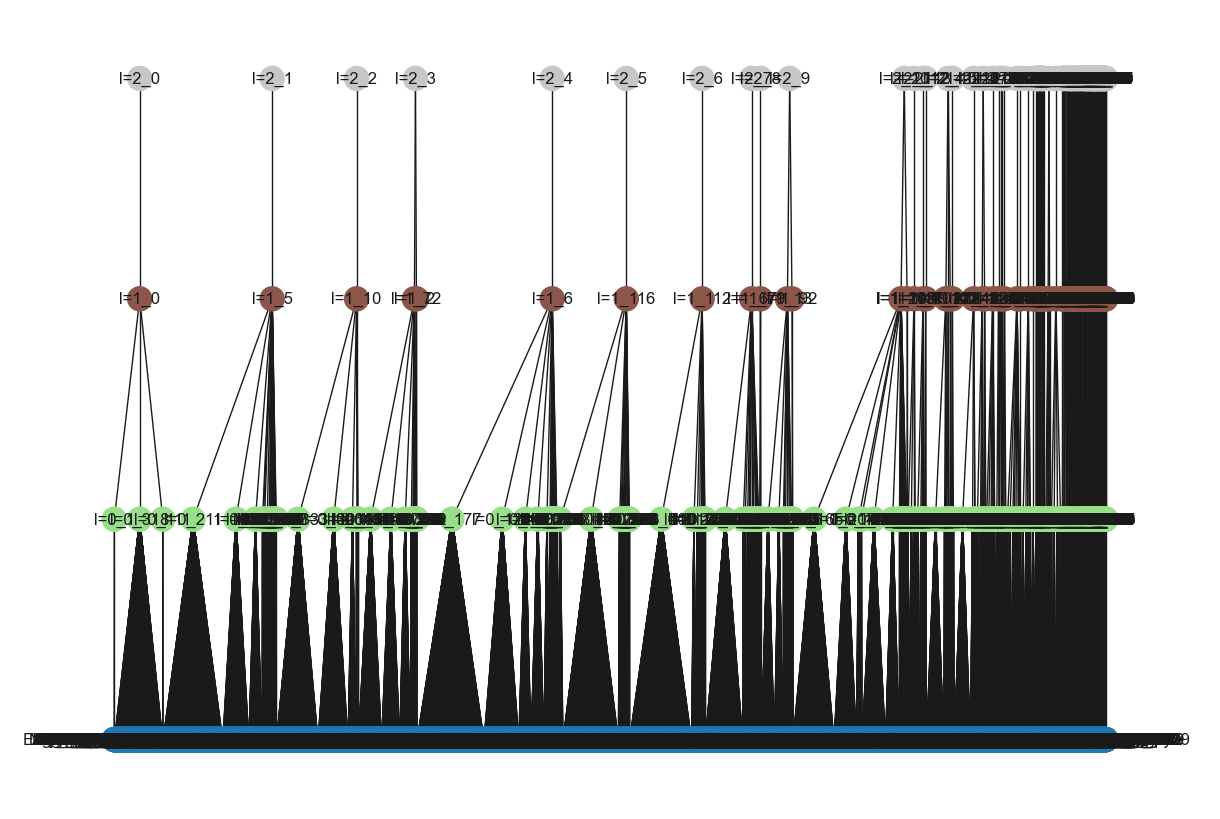

In [13]:
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
# Plotting the hierarchial organisation of the communities 'Deddrogram'.
pg = nx.DiGraph()

last_part = None
for l, part in enumerate(dendrogram):
    print(l, len(part))
    for n, comm in part.items():
        # level = ?, community = ?
        nom = "l={}_{}".format(l, comm)
        pg.add_node(nom, comm=comm, color=l+1)

        if l == 0:
            pg.add_node(n, comm=comm, color=0)
            pg.add_edge(nom, n)
        else: 
            pg.add_edge(nom, "l={}_{}".format(l-1, n))
    last_part = part
   

plt.figure(figsize=(12,8))

colors = list(nx.get_node_attributes(pg, 'color').values())

pos = graphviz_layout(pg, prog='dot')
nx.draw(pg, pos, with_labels=True, arrows=False, node_color=colors, vmin=0, vmax=len(dendrogram) + 1, cmap=plt.cm.tab20)
# 40 seconds

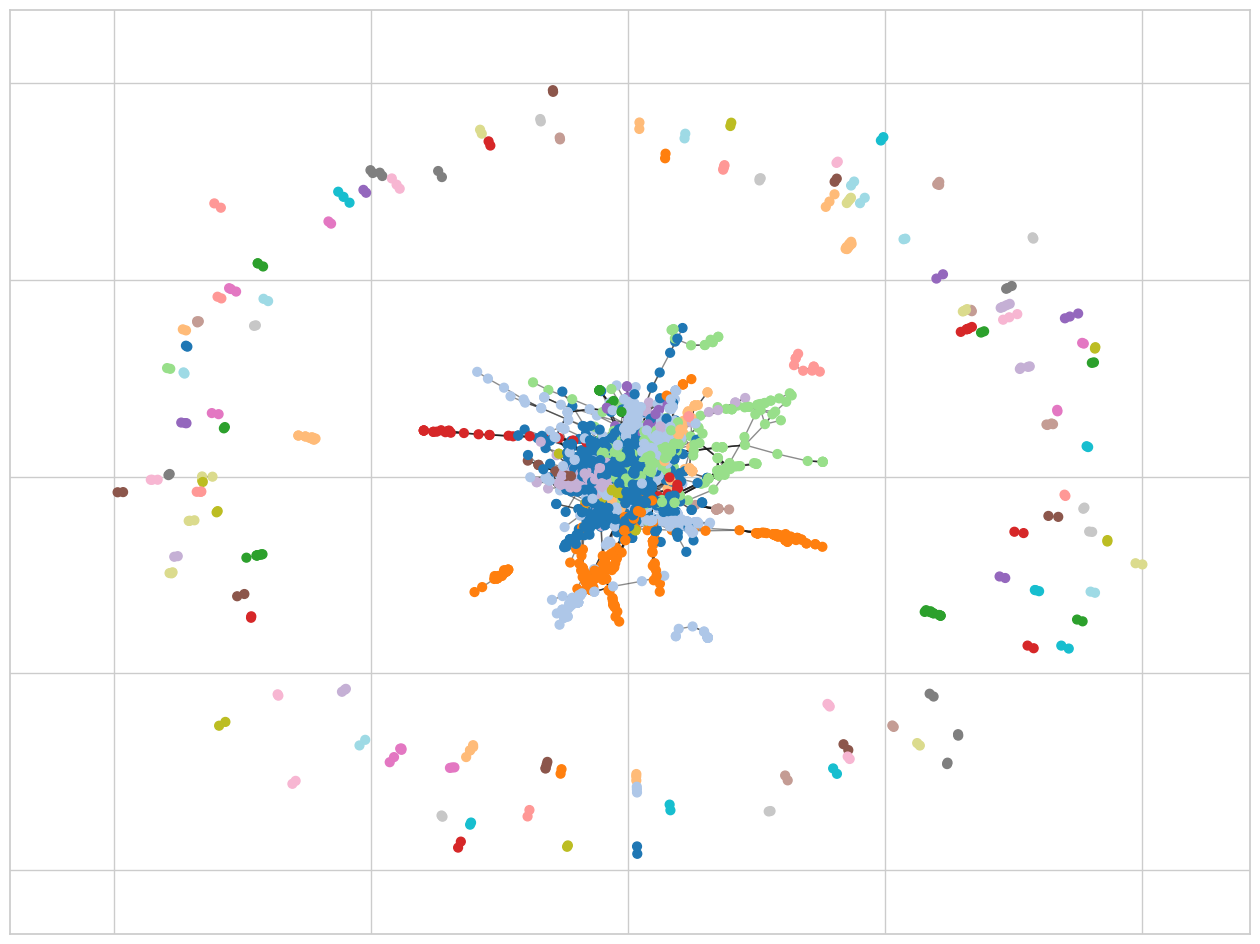

In [ ]:
# Plotting the best partition for cluster analysis.
plt.figure(figsize=(16, 12))

partition = community.best_partition(G)

#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(G, seed=RANDOM_STATE)
node_list = [n for n, n_com in sorted(partition.items())]
node_colors = [n_com for n, n_com in sorted(partition.items())]
    
nx.draw_networkx_nodes(G, pos, node_list, node_size=40, 
                       # the arguments below here make each community a different color
                       vmin=0, vmax=size,
                       node_color=node_colors, cmap=plt.cm.tab20)
    #print(count)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()
# 3 minutes

In [15]:
# Top 3 largest clusters' analysis.

import networkx as nx
import community
from collections import Counter

best_partition = community.best_partition(G, random_state=RANDOM_STATE)

community_sizes = Counter(best_partition.values())

# 3 largest communities
top_communities = [com for com, size in community_sizes.most_common(3)]

# Create subgraphs
subgraphs = {com: G.subgraph([node for node, c in best_partition.items() if c == com]) for com in top_communities}

# statistics
for com, subgraph in subgraphs.items():
    num_nodes = subgraph.number_of_nodes()
    num_edges = subgraph.number_of_edges()
    density = nx.density(subgraph)
    avg_degree = sum(dict(subgraph.degree()).values()) / num_nodes
    clustering_coeff = nx.average_clustering(subgraph)
    
    betweenness = nx.betweenness_centrality(subgraph, normalized=True)
    avg_betweenness = sum(betweenness.values()) / num_nodes

    print(f"Community {com}:")
    print(f"- Nodes: {num_nodes}")
    print(f"- Edges: {num_edges}")
    print(f"- Density: {density:.4f}")
    print(f"- Average Degree: {avg_degree:.2f}")
    print(f"- Clustering Coefficient: {clustering_coeff:.4f}")
    print(f"- Average Betweenness Centrality: {avg_betweenness:.6f}")
# 7 minutes

Community 4:
- Nodes: 1194
- Edges: 139159
- Density: 0.1954
- Average Degree: 233.10
- Clustering Coefficient: 0.7773
- Average Betweenness Centrality: 0.001149
Community 10:
- Nodes: 1002
- Edges: 83293
- Density: 0.1661
- Average Degree: 166.25
- Clustering Coefficient: 0.7825
- Average Betweenness Centrality: 0.001611
Community 1:
- Nodes: 996
- Edges: 69228
- Density: 0.1397
- Average Degree: 139.01
- Clustering Coefficient: 0.7355
- Average Betweenness Centrality: 0.001952


## Finding k-Cliques (CPM Method)

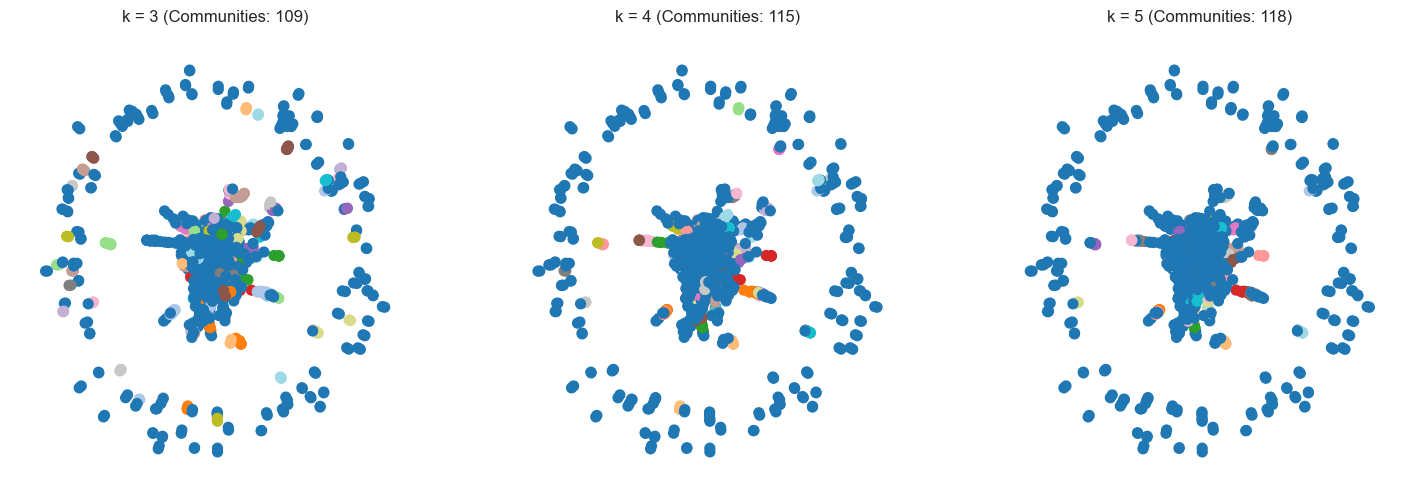

In [ ]:
sg = nx.depth_first_search.dfs_tree(G, None, 4)
sg = G.subgraph(sg.nodes)

k_values = [3, 4, 5]

# Initialize subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
pos = nx.spring_layout(sg, seed=RANDOM_STATE)

for i, k in enumerate(k_values):
    communities = list(nx.community.k_clique_communities(sg, k))
    
    node_colors = {}
    for j, community in enumerate(communities):
        for node in community:
            node_colors[node] = j 
    # color list
    colors = [node_colors.get(node, -1) for node in sg.nodes()]
    
    ax = axes[i]
    nx.draw(sg, pos, ax=ax, node_color=colors, cmap=plt.cm.tab20, with_labels=False, node_size=50, edge_color="gray")
    ax.set_title(f"k = {k} (Communities: {len(communities)})")

plt.show()
# 15 minutes